# Reading the results

In [246]:
import pandas as pd

PREGUNTAS = pd.read_excel('../resultados_azure/CATALOGO/PREGUNTAS.xls')
CANTON = pd.read_excel('../resultados_azure/CATALOGO/CANTON.xls')
CIRCUNSCRIPCION = pd.read_excel('../resultados_azure/CATALOGO/CIRCUNSCRIPCION.xls')
DIGNIDAD = pd.read_excel('../resultados_azure/CATALOGO/DIGNIDAD.xls')
JUNTA = pd.read_excel('../resultados_azure/CATALOGO/JUNTA.xls')
PARROQUIA = pd.read_excel('../resultados_azure/CATALOGO/PARROQUIA.xls')
OPCIONES = pd.read_excel('../resultados_azure/CATALOGO/OPCIONES.xls')
PROVINCIA = pd.read_excel('../resultados_azure/CATALOGO/PROVINCIA.xls')
ZONA = pd.read_excel('../resultados_azure/CATALOGO/ZONA.xls')

bases_azure = [
    "../resultados_azure/A_REFERENDUM_PREGUNTA_2024.04.25_01.50.01.txt",
    "../resultados_azure/B_REFERENDUM_PREGUNTA1_2024.04.25_01.50.02.txt",
    "../resultados_azure/C_REFERENDUM_PREGUNTA2_2024.04.25_01.50.03.txt",
    "../resultados_azure/D_REFERENDUM_PREGUNTA3_2024.04.25_01.50.04.txt",
    "../resultados_azure/E_REFERENDUM_PREGUNTA4_2024.04.25_01.50.05.txt",
    "../resultados_azure/F_CONSULTAPOPULAR_PREGUNTA1_2024.04.25_01.55.06.txt",
    "../resultados_azure/G_CONSULTAPOPULAR_PREGUNTA2_2024.04.25_01.55.08.txt",
    "../resultados_azure/H_CONSULTAPOPULAR_PREGUNTA3_2024.04.25_01.55.09.txt",
    "../resultados_azure/I_CONSULTAPOPULAR_PREGUNTA4_2024.04.25_01.55.09.txt"
]

final = pd.DataFrame()
for i in bases_azure:
    lectura =  pd.read_table(i,sep='|',names= 
                             ['COD_DIGNIDAD','COD_PROVINCIA',
                              'COD_CIRCUNSCRIPCION','COD_CANTON','COD_PARROQUIA',
                              'COD_ZONA','NUM_JUNTA','SEX_JUNTA','COD_JUNTA',
                              'COD_PREGUNTA','COD_OPCION','NUM_SUF_ACTA','BLANCOS','NULOS','FIN_RESULTADO'])
    final = pd.concat([final,lectura])

exterior = ['EUROPA ASIA Y OCEANIA', 'EE.UU CANADA', 'AMERICA LATINA EL CARIBE Y AFRICA']
baseP = final

baseP = pd.merge(DIGNIDAD,baseP,on='COD_DIGNIDAD')
baseP = pd.merge(PROVINCIA,baseP,on='COD_PROVINCIA')
baseP = pd.merge(CANTON[['COD_CANTON','NOM_CANTON']],baseP,on='COD_CANTON')
baseP = pd.merge(PARROQUIA[['COD_PARROQUIA','NOM_PARROQUIA']],baseP,on='COD_PARROQUIA')
#baseP = pd.merge(Est_parroquia,baseP,on='COD_PARROQUIA')
baseP = pd.merge(PREGUNTAS[['COD_PREGUNTA','NOM_PREGUNTA','LIS_PREGUNTA']],baseP,on='COD_PREGUNTA')
baseP = pd.merge(OPCIONES[['COD_OPCION','NOM_OPCION']],baseP,on='COD_OPCION')

baseP = baseP[-baseP['NOM_PROVINCIA'].isin(exterior)]

resultadosP = baseP.groupby(by = ['NOM_PREGUNTA','NOM_PROVINCIA','NOM_OPCION']).sum(numeric_only=True)[['FIN_RESULTADO']].reset_index()
resultadosP = resultadosP[-resultadosP['NOM_PROVINCIA'].isin(exterior)]


preguntas = resultadosP['NOM_PREGUNTA'].unique()
provincias = resultadosP['NOM_PROVINCIA'].unique()


def proporcion(NO,SI):
    if NO>=SI:
        return NO/SI, 'NO'
    return SI/NO, 'SI'
baseP.groupby(by = ['NOM_PREGUNTA','NOM_PROVINCIA','NOM_OPCION']).sum(numeric_only=True)[['FIN_RESULTADO']].reset_index()
resultado_prop = pd.pivot_table(baseP,'FIN_RESULTADO',aggfunc='sum',index=['NOM_PREGUNTA','NOM_PROVINCIA'],columns='NOM_OPCION').reset_index()
resultado_prop['prop'] = resultado_prop.apply(lambda row: proporcion(row['NO'],row['SI']),axis=1)
resultado_prop = pd.concat([resultado_prop,resultado_prop['prop'].apply(lambda x: pd.Series(str(x).strip("()'").split(", '")))],axis=1)
resultado_prop['Normalizacion'] = resultado_prop[0].astype(float)/5
resultado_prop['TOTAL'] = resultado_prop['NO'] + resultado_prop['SI']
resultado_prop['NO_prop'] = resultado_prop['NO']/resultado_prop['TOTAL']
resultado_prop['SI_prop'] = resultado_prop['SI']/resultado_prop['TOTAL']
resultado_prop['NO %'] = resultado_prop['NO_prop'].apply(lambda x: f"{x:.2%}")
resultado_prop['SI %'] = resultado_prop['SI_prop'].apply(lambda x: f"{x:.2%}")

for pregunta in preguntas:
    df1 = resultado_prop[resultado_prop['NOM_PREGUNTA']==pregunta][['NOM_PROVINCIA','SI %','NO %']]
    df2 = resultado_prop[resultado_prop['NOM_PREGUNTA']==pregunta][['NOM_PROVINCIA',0]]
    
    prop_SI = resultado_prop[(resultado_prop['NOM_PREGUNTA']==pregunta) & (resultado_prop[1]=='SI')][['NOM_PROVINCIA','SI_prop']].set_index('NOM_PROVINCIA').to_dict()['SI_prop']
    prop_NO = resultado_prop[(resultado_prop['NOM_PREGUNTA']==pregunta) & (resultado_prop[1]=='NO')][['NOM_PROVINCIA','NO_prop']].set_index('NOM_PROVINCIA').to_dict()['NO_prop']
    
    dic_SI = resultado_prop[(resultado_prop['NOM_PREGUNTA']==pregunta) & (resultado_prop[1]=='SI')][['NOM_PROVINCIA','Normalizacion',0]]
    dic_SI_norm = dic_SI.copy() 
    if dic_SI.shape[0] == 0:
        dic_SI = {}
        dic_SI_norm = {}
    else:
        dic_SI[0] = dic_SI[0].astype(float)
        dic_SI = dic_SI.set_index('NOM_PROVINCIA').to_dict()[0]    
        dic_SI_norm['Normalizacion'] = dic_SI_norm['Normalizacion'].astype(float)
        dic_SI_norm = dic_SI_norm.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
        
    dic_NO = resultado_prop[(resultado_prop['NOM_PREGUNTA']==pregunta) & (resultado_prop[1]=='NO')][['NOM_PROVINCIA','Normalizacion',0]]
    dic_NO_norm = dic_NO.copy() 
    if dic_NO.shape[0] == 0:
        dic_NO = {}
        dic_NO_norm = {}
    else:

        dic_NO[0] = dic_NO[0].astype(float)
        dic_NO = dic_NO.set_index('NOM_PROVINCIA').to_dict()[0]     
        dic_NO_norm['Normalizacion'] = dic_NO_norm['Normalizacion'].astype(float)
        dic_NO_norm = dic_NO_norm.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
    



resultado_prop.head()



WARNING *** file size (2252492) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,NOM_PREGUNTA,NOM_PROVINCIA,NO,SI,prop,0,1,Normalizacion,TOTAL,NO_prop,SI_prop,NO %,SI %
0,A - REFERÉNDUM - PREGUNTA,AZUAY,99174,340819,"(3.436576118740799, SI)",3.436576118740799,SI,0.687315,439993,0.225399,0.774601,22.54%,77.46%
1,A - REFERÉNDUM - PREGUNTA,BOLIVAR,38756,88871,"(2.2930901021777275, SI)",2.2930901021777275,SI,0.458618,127627,0.303666,0.696334,30.37%,69.63%
2,A - REFERÉNDUM - PREGUNTA,CARCHI,30503,84347,"(2.765203422614169, SI)",2.765203422614169,SI,0.553041,114850,0.265590,0.734410,26.56%,73.44%
3,A - REFERÉNDUM - PREGUNTA,CAÑAR,30734,94348,"(3.0698249495672547, SI)",3.0698249495672547,SI,0.613965,125082,0.245711,0.754289,24.57%,75.43%
4,A - REFERÉNDUM - PREGUNTA,CHIMBORAZO,77728,209766,"(2.6987186084808563, SI)",2.6987186084808563,SI,0.539744,287494,0.270364,0.729636,27.04%,72.96%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,NOM_PROVINCIA,PROP,Color Hex,RESPUESTA
0,AZUAY,0.680769,#51aaf0,SI
1,BOLIVAR,0.613360,#62b3f1,SI
2,CARCHI,0.648024,#5aaff1,SI
3,CAÑAR,0.658776,#57adf1,SI
4,CHIMBORAZO,0.656564,#57adf1,SI
5,COTOPAXI,0.577559,#6cb8f2,SI
6,EL ORO,0.665270,#55acf0,SI
7,ESMERALDAS,0.622848,#60b2f1,SI
8,GALAPAGOS,0.752050,#3fa2ee,SI
9,GUAYAS,0.660749,#56adf0,SI


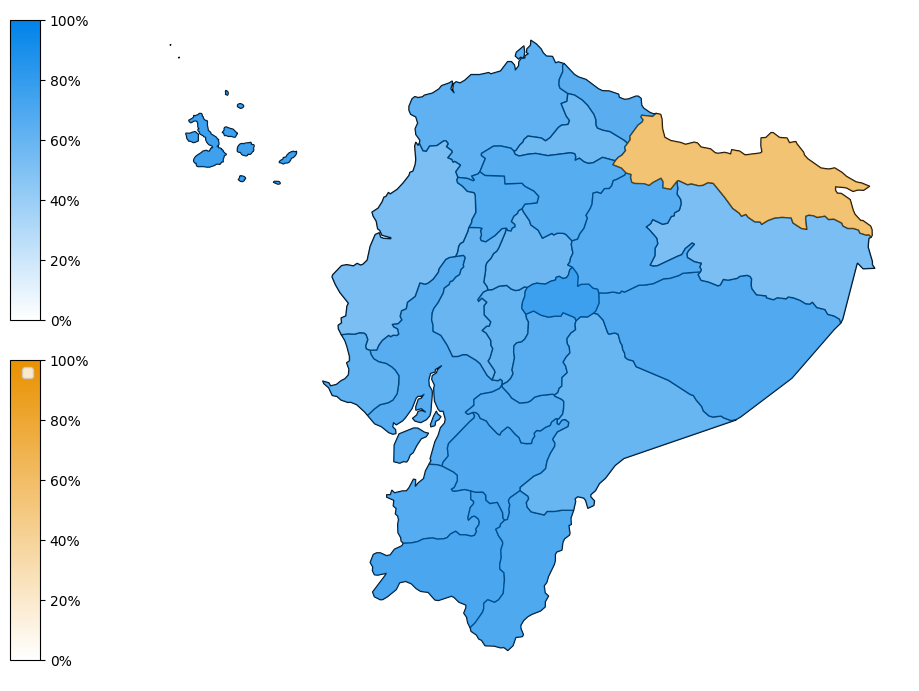

In [234]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.ticker as ticker

# Load GeoJSON file
gdf = gpd.read_file("Ecuador.geojson")
gdf['name'] = gdf['name'].str.upper()
gdf['name'] = gdf['name'].str.replace('SANTO DOMINGO DE LOS TSACHILAS', 'STO DGO TSACHILAS')

color_si = '#0083E9'
color_no = '#E99100'

# Plot the shapes with a heatmap-like effect based on the score
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='black')

for name, score in prop_SI.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color=color_si, alpha=score, linewidth=0, label=name)
    
for name, score in prop_NO.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color=color_no, alpha=score, linewidth=0, label=name)

# Create a colormap with a gradient using the specified color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_si)])

# Crea un objeto Normalizar para mapear los valores al rango 0-1
norm = Normalize(vmin=0, vmax=1)

valores_a_convertir_si = prop_SI.values()
valores_a_convertir_no = prop_NO.values()

# Obtiene los colores correspondientes a los valores dados
colores_correspondientes_si = [cmap(norm(valor)) for valor in valores_a_convertir_si]



# Convierte los colores de formato RGB a formato hexadecimal
colores_hex_si = [plt.cm.colors.to_hex(color) for color in colores_correspondientes_si]


# Add colorbar
cbar_ax1 = fig.add_axes([0, 0.52, 0.03, 0.3])
norm = Normalize(vmin=0, vmax=1)
cbar = ColorbarBase(ax=cbar_ax1, cmap=cmap, norm=norm)
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))  # Set the labels to percentages from 1 to 100%

# Create a colormap with a gradient using the specified color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_no)])
colores_correspondientes_no = [cmap(norm(valor)) for valor in valores_a_convertir_no]
colores_hex_no = [plt.cm.colors.to_hex(color) for color in colores_correspondientes_no]
# Add colorbar
cbar_ax2 = fig.add_axes([0, 0.18, 0.03, 0.3])
norm = Normalize(vmin=0, vmax=1)
cbar = ColorbarBase(ax=cbar_ax2, cmap=cmap, norm=norm)
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))  # Set the labels to percentages from 1 to 100%

plt.legend()
ax.axis('off')
# Save the plot as a PNG image
plt.savefig('mapas/heatmap_plot.png', dpi=300, transparent=True)  # Adjust dpi as needed

data_SI = {
    'NOM_PROVINCIA' : prop_SI.keys(),
    'PROP' : prop_SI.values()
}
data_SI = pd.DataFrame(data_SI)
data_SI['Color Hex'] = colores_hex_si
data_SI['RESPUESTA'] = 'SI'

data_NO = {
    'NOM_PROVINCIA' : prop_NO.keys(),
    'PROP' : prop_NO.values()
}
data_NO = pd.DataFrame(data_NO)
data_NO['Color Hex'] = colores_hex_no
data_NO['RESPUESTA'] = 'NO'

data_1 = pd.concat([data_SI,data_NO])
data_1

# Plot 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,NOM_PROVINCIA,PROP,Color Hex,RESPUESTA
0,AZUAY,2.132532,#92caf6,SI
1,BOLIVAR,1.586382,#aed8f8,SI
2,CARCHI,1.841104,#a1d1f7,SI
3,CAÑAR,1.930627,#9dcff7,SI
4,CHIMBORAZO,1.911751,#9ed0f7,SI
5,COTOPAXI,1.367197,#b9ddf9,SI
6,EL ORO,1.987481,#9acef6,SI
7,ESMERALDAS,1.651450,#abd6f8,SI
8,GALAPAGOS,3.033067,#64b4f2,SI
9,GUAYAS,1.947668,#9ccff6,SI


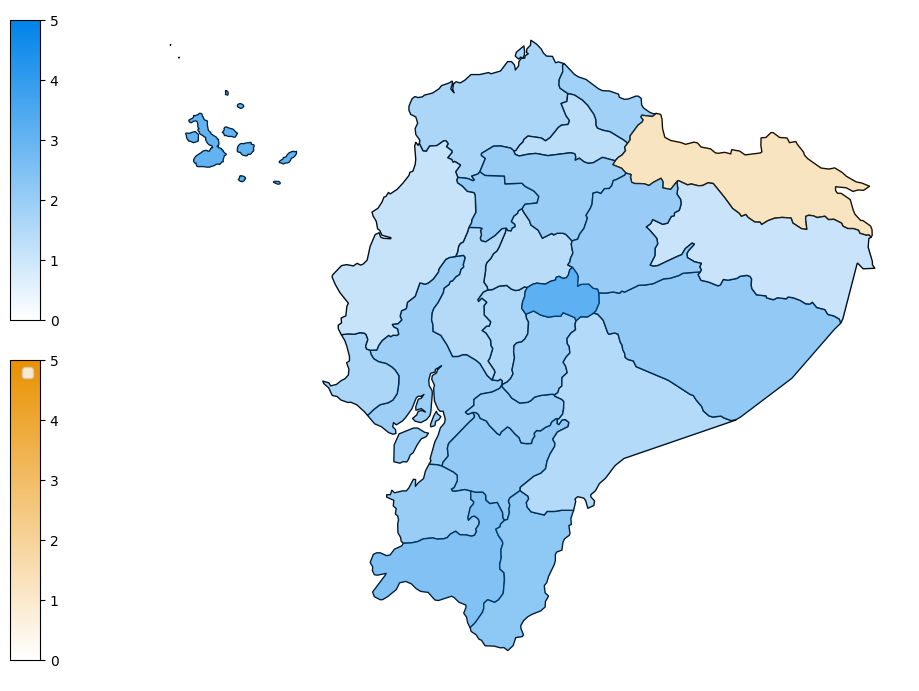

In [250]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.ticker as ticker

# Load GeoJSON file
gdf = gpd.read_file("Ecuador.geojson")
gdf['name'] = gdf['name'].str.upper()
gdf['name'] = gdf['name'].str.replace('SANTO DOMINGO DE LOS TSACHILAS', 'STO DGO TSACHILAS')

color_si = '#0083E9'
color_no = '#E99100'

# Plot the shapes with a heatmap-like effect based on the score
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='black')

for name, score in dic_SI_norm.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color=color_si, alpha=score, linewidth=0, label=name)
    
for name, score in dic_NO_norm.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color=color_no, alpha=score, linewidth=0, label=name)

# Create a colormap with a gradient using the specified color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_si)])

# Crea un objeto Normalizar para mapear los valores al rango 0-1
norm = Normalize(vmin=0, vmax=5)

valores_a_convertir_si = dic_SI.values()
valores_a_convertir_no = dic_NO.values()

# Obtiene los colores correspondientes a los valores dados
colores_correspondientes_si = [cmap(norm(valor)) for valor in valores_a_convertir_si]



# Convierte los colores de formato RGB a formato hexadecimal
colores_hex_si = [plt.cm.colors.to_hex(color) for color in colores_correspondientes_si]


# Add colorbar
cbar_ax1 = fig.add_axes([0, 0.52, 0.03, 0.3])

cbar = ColorbarBase(ax=cbar_ax1, cmap=cmap, norm=norm, orientation='vertical')
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))  # Set the labels to percentages from 1 to 100%

# Create a colormap with a gradient using the specified color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_no)])
colores_correspondientes_no = [cmap(norm(valor)) for valor in valores_a_convertir_no]
colores_hex_no = [plt.cm.colors.to_hex(color) for color in colores_correspondientes_no]
# Add colorbar
cbar_ax2 = fig.add_axes([0, 0.18, 0.03, 0.3])

cbar = ColorbarBase(ax=cbar_ax2, cmap=cmap, norm=norm, orientation='vertical')

#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))  # Set the labels to percentages from 1 to 100%

plt.legend()
ax.axis('off')
# Save the plot as a PNG image
plt.savefig('mapas/heatmap_plot.png', dpi=300, transparent=True)  # Adjust dpi as needed

data_SI = {
    'NOM_PROVINCIA' : dic_SI.keys(),
    'PROP' : dic_SI.values()
}
data_SI = pd.DataFrame(data_SI)
data_SI['Color Hex'] = colores_hex_si
data_SI['RESPUESTA'] = 'SI'

data_NO = {
    'NOM_PROVINCIA' : dic_NO.keys(),
    'PROP' : dic_NO.values()
}
data_NO = pd.DataFrame(data_NO)
data_NO['Color Hex'] = colores_hex_no
data_NO['RESPUESTA'] = 'NO'

data_1 = pd.concat([data_SI,data_NO])
data_1

In [203]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Define el color hexadecimal
color_hex = '#96c3c4'

# Crea un mapa de color con un gradiente usando el color especificado
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_hex)])

# Define el rango de valores para el colorbar
values = [0, 1, 2, 3, 4, 5]

# Crea un objeto Normalizar para mapear los valores al rango 0-1
norm = Normalize(vmin=min(values), vmax=max(values))

# Lista de valores para los que quieres obtener el color correspondiente
valores_a_convertir = [1, 3, 4]

# Obtiene los colores correspondientes a los valores dados
colores_correspondientes = [cmap(norm(valor)) for valor in valores_a_convertir]

# Convierte los colores de formato RGB a formato hexadecimal
colores_hex = [plt.cm.colors.to_hex(color) for color in colores_correspondientes]

# O puedes imprimir los colores en formato RGB directamente
colores_rgb = [plt.cm.colors.to_rgba(color, alpha=False) for color in colores_correspondientes]

print("Valores:", valores_a_convertir)
print("Colores correspondientes en formato Hex:", colores_hex)
print("Colores correspondientes en formato RGB:", colores_rgb)


Valores: [1, 3, 4]
Colores correspondientes en formato Hex: ['#eaf3f3', '#c0dbdc', '#abcfd0']
Colores correspondientes en formato RGB: [(0.9176470588235294, 0.9529411764705882, 0.9537254901960784, False), (0.7529411764705882, 0.8588235294117647, 0.8611764705882353, False), (0.6705882352941177, 0.8117647058823529, 0.8149019607843138, False)]


In [231]:
data_1

,NOM_PROVINCIA,PROP,Color Hex,RESPUESTA
0,AZUAY,0.680769,#51aaf0,SI
1,BOLIVAR,0.613360,#62b3f1,SI
2,CARCHI,0.648024,#5aaff1,SI
3,CAÑAR,0.658776,#57adf1,SI
4,CHIMBORAZO,0.656564,#57adf1,SI
5,COTOPAXI,0.577559,#6cb8f2,SI
6,EL ORO,0.665270,#55acf0,SI
7,ESMERALDAS,0.622848,#60b2f1,SI
8,GALAPAGOS,0.752050,#3fa2ee,SI
9,GUAYAS,0.660749,#56adf0,SI


In [187]:
import pandas as pd

PREGUNTAS = pd.read_excel('../resultados_azure/CATALOGO/PREGUNTAS.xls')
CANTON = pd.read_excel('../resultados_azure/CATALOGO/CANTON.xls')
CIRCUNSCRIPCION = pd.read_excel('../resultados_azure/CATALOGO/CIRCUNSCRIPCION.xls')
DIGNIDAD = pd.read_excel('../resultados_azure/CATALOGO/DIGNIDAD.xls')
JUNTA = pd.read_excel('../resultados_azure/CATALOGO/JUNTA.xls')
PARROQUIA = pd.read_excel('../resultados_azure/CATALOGO/PARROQUIA.xls')
OPCIONES = pd.read_excel('../resultados_azure/CATALOGO/OPCIONES.xls')
PROVINCIA = pd.read_excel('../resultados_azure/CATALOGO/PROVINCIA.xls')
ZONA = pd.read_excel('../resultados_azure/CATALOGO/ZONA.xls')

bases_azure = [
    "../resultados_azure/A_REFERENDUM_PREGUNTA_2024.04.25_01.50.01.txt",
    "../resultados_azure/B_REFERENDUM_PREGUNTA1_2024.04.25_01.50.02.txt",
    "../resultados_azure/C_REFERENDUM_PREGUNTA2_2024.04.25_01.50.03.txt",
    "../resultados_azure/D_REFERENDUM_PREGUNTA3_2024.04.25_01.50.04.txt",
    "../resultados_azure/E_REFERENDUM_PREGUNTA4_2024.04.25_01.50.05.txt",
    "../resultados_azure/F_CONSULTAPOPULAR_PREGUNTA1_2024.04.25_01.55.06.txt",
    "../resultados_azure/G_CONSULTAPOPULAR_PREGUNTA2_2024.04.25_01.55.08.txt",
    "../resultados_azure/H_CONSULTAPOPULAR_PREGUNTA3_2024.04.25_01.55.09.txt",
    "../resultados_azure/I_CONSULTAPOPULAR_PREGUNTA4_2024.04.25_01.55.09.txt"
]

final = pd.DataFrame()
for i in bases_azure:
    lectura =  pd.read_table(i,sep='|',names= 
                             ['COD_DIGNIDAD','COD_PROVINCIA',
                              'COD_CIRCUNSCRIPCION','COD_CANTON','COD_PARROQUIA',
                              'COD_ZONA','NUM_JUNTA','SEX_JUNTA','COD_JUNTA',
                              'COD_PREGUNTA','COD_OPCION','NUM_SUF_ACTA','BLANCOS','NULOS','FIN_RESULTADO'])
    final = pd.concat([final,lectura])


baseP = final

baseP = pd.merge(DIGNIDAD,baseP,on='COD_DIGNIDAD')
baseP = pd.merge(PROVINCIA,baseP,on='COD_PROVINCIA')
baseP = pd.merge(CANTON[['COD_CANTON','NOM_CANTON']],baseP,on='COD_CANTON')
baseP = pd.merge(PARROQUIA[['COD_PARROQUIA','NOM_PARROQUIA']],baseP,on='COD_PARROQUIA')
#baseP = pd.merge(Est_parroquia,baseP,on='COD_PARROQUIA')
baseP = pd.merge(PREGUNTAS[['COD_PREGUNTA','NOM_PREGUNTA','LIS_PREGUNTA']],baseP,on='COD_PREGUNTA')
baseP = pd.merge(OPCIONES[['COD_OPCION','NOM_OPCION']],baseP,on='COD_OPCION')
resultadosP = baseP.groupby(by = ['NOM_PREGUNTA','NOM_PROVINCIA','NOM_OPCION']).sum(numeric_only=True)[['FIN_RESULTADO']].reset_index()

preguntas = resultadosP['NOM_PREGUNTA'].unique()
provincias = resultadosP['NOM_PROVINCIA'].unique()



resultados_porcentajes = pd.DataFrame()
for pregunta in preguntas:
    for provincia in provincias:
        aux = resultadosP[resultadosP['NOM_PREGUNTA']==pregunta]
        aux = aux[aux['NOM_PROVINCIA']==provincia]
        total = aux['FIN_RESULTADO'].sum()
        aux['PORCENTAJE'] = aux['FIN_RESULTADO']/total
        aux['%'] = aux['PORCENTAJE'].apply(lambda x: f"{x:.2%}")
        
def proporcion(NO,SI):
    if NO>=SI:
        return NO/SI, 'NO'
    return SI/NO, 'SI'
baseP.groupby(by = ['NOM_PREGUNTA','NOM_PROVINCIA','NOM_OPCION']).sum(numeric_only=True)[['FIN_RESULTADO']].reset_index()
resultado_prop = pd.pivot_table(baseP,'FIN_RESULTADO',aggfunc='sum',index=['NOM_PREGUNTA','NOM_PROVINCIA'],columns='NOM_OPCION').reset_index()
resultado_prop['prop'] = resultado_prop.apply(lambda row: proporcion(row['NO'],row['SI']),axis=1)
resultado_prop = pd.concat([resultado_prop,resultado_prop['prop'].apply(lambda x: pd.Series(str(x).strip("()'").split(", '")))],axis=1)
resultado_prop['Normalizacion'] = resultado_prop[0].astype(float)/5
resultado_prop['TOTAL'] = resultado_prop['NO'] + resultado_prop['SI']
resultado_prop['NO_prop'] = resultado_prop['NO']/resultado_prop['TOTAL']
resultado_prop['SI_prop'] = resultado_prop['SI']/resultado_prop['TOTAL']
resultado_prop['NO %'] = resultado_prop['NO_prop'].apply(lambda x: f"{x:.2%}")
resultado_prop['SI %'] = resultado_prop['SI_prop'].apply(lambda x: f"{x:.2%}")
dic_SI = resultado_prop[(resultado_prop['NOM_PREGUNTA']=='D - REFERÉNDUM - PREGUNTA 3') & (resultado_prop[1]=='SI')][['NOM_PROVINCIA','Normalizacion']]
dic_SI = dic_SI.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
dic_NO = resultado_prop[(resultado_prop['NOM_PREGUNTA']=='D - REFERÉNDUM - PREGUNTA 3') & (resultado_prop[1]=='NO')][['NOM_PROVINCIA','Normalizacion']]
dic_NO = dic_NO.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
resultado_prop







WARNING *** file size (2252492) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,NOM_PREGUNTA,NOM_PROVINCIA,NO,SI,prop,0,1,Normalizacion,TOTAL,NO_prop,SI_prop,NO %,SI %
0,A - REFERÉNDUM - PREGUNTA,AMERICA LATINA EL CARIBE Y AFRICA,1439,5245,"(3.6448922863099376, SI)",3.6448922863099376,SI,0.728978,6684,0.215290,0.784710,21.53%,78.47%
1,A - REFERÉNDUM - PREGUNTA,AZUAY,99174,340819,"(3.436576118740799, SI)",3.436576118740799,SI,0.687315,439993,0.225399,0.774601,22.54%,77.46%
2,A - REFERÉNDUM - PREGUNTA,BOLIVAR,38756,88871,"(2.2930901021777275, SI)",2.2930901021777275,SI,0.458618,127627,0.303666,0.696334,30.37%,69.63%
3,A - REFERÉNDUM - PREGUNTA,CARCHI,30503,84347,"(2.765203422614169, SI)",2.765203422614169,SI,0.553041,114850,0.265590,0.734410,26.56%,73.44%
4,A - REFERÉNDUM - PREGUNTA,CAÑAR,30734,94348,"(3.0698249495672547, SI)",3.0698249495672547,SI,0.613965,125082,0.245711,0.754289,24.57%,75.43%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,I - CONSULTA POPULAR - PREGUNTA 4,SANTA ELENA,79453,128573,"(1.6182271279876153, SI)",1.6182271279876153,SI,0.323645,208026,0.381938,0.618062,38.19%,61.81%
239,I - CONSULTA POPULAR - PREGUNTA 4,STO DGO TSACHILAS,94036,191919,"(2.0409098643072867, SI)",2.0409098643072867,SI,0.408182,285955,0.328849,0.671151,32.88%,67.12%
240,I - CONSULTA POPULAR - PREGUNTA 4,SUCUMBIOS,64576,53629,"(1.2041246340599303, NO)",1.2041246340599303,NO,0.240825,118205,0.546305,0.453695,54.63%,45.37%
241,I - CONSULTA POPULAR - PREGUNTA 4,TUNGURAHUA,82066,261227,"(3.1831330880023394, SI)",3.1831330880023394,SI,0.636627,343293,0.239055,0.760945,23.91%,76.09%


In [184]:
def proporcion(NO,SI):
    if NO>=SI:
        return NO/SI, 'NO'
    return SI/NO, 'SI'
baseP.groupby(by = ['NOM_PREGUNTA','NOM_PROVINCIA','NOM_OPCION']).sum(numeric_only=True)[['FIN_RESULTADO']].reset_index()
resultado_prop = pd.pivot_table(baseP,'FIN_RESULTADO',aggfunc='sum',index=['NOM_PREGUNTA','NOM_PROVINCIA'],columns='NOM_OPCION').reset_index()
resultado_prop['prop'] = resultado_prop.apply(lambda row: proporcion(row['NO'],row['SI']),axis=1)
resultado_prop = pd.concat([resultado_prop,resultado_prop['prop'].apply(lambda x: pd.Series(str(x).strip("()'").split(", '")))],axis=1)
resultado_prop['Normalizacion'] = resultado_prop[0].astype(float)/5
resultado_prop['TOTAL'] = resultado_prop['NO'] + resultado_prop['SI']
resultado_prop['NO %'] = (resultado_prop['NO']/resultado_prop['TOTAL']).apply(lambda x: f"{x:.2%}")
resultado_prop['SI %'] = (resultado_prop['SI']/resultado_prop['TOTAL']).apply(lambda x: f"{x:.2%}")
dic_SI = resultado_prop[(resultado_prop['NOM_PREGUNTA']=='D - REFERÉNDUM - PREGUNTA 3') & (resultado_prop[1]=='SI')][['NOM_PROVINCIA','Normalizacion']]
dic_SI = dic_SI.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
dic_NO = resultado_prop[(resultado_prop['NOM_PREGUNTA']=='D - REFERÉNDUM - PREGUNTA 3') & (resultado_prop[1]=='NO')][['NOM_PROVINCIA','Normalizacion']]
dic_NO = dic_NO.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
resultado_prop




,NOM_PREGUNTA,NOM_PROVINCIA,NO,SI,prop,0,1,Normalizacion,TOTAL,NO %,SI %
0,A - REFERÉNDUM - PREGUNTA,AMERICA LATINA EL CARIBE Y AFRICA,1439,5245,"(3.6448922863099376, SI)",3.6448922863099376,SI,0.728978,6684,21.53%,78.47%
1,A - REFERÉNDUM - PREGUNTA,AZUAY,99174,340819,"(3.436576118740799, SI)",3.436576118740799,SI,0.687315,439993,22.54%,77.46%
2,A - REFERÉNDUM - PREGUNTA,BOLIVAR,38756,88871,"(2.2930901021777275, SI)",2.2930901021777275,SI,0.458618,127627,30.37%,69.63%
3,A - REFERÉNDUM - PREGUNTA,CARCHI,30503,84347,"(2.765203422614169, SI)",2.765203422614169,SI,0.553041,114850,26.56%,73.44%
4,A - REFERÉNDUM - PREGUNTA,CAÑAR,30734,94348,"(3.0698249495672547, SI)",3.0698249495672547,SI,0.613965,125082,24.57%,75.43%
...,...,...,...,...,...,...,...,...,...,...,...
238,I - CONSULTA POPULAR - PREGUNTA 4,SANTA ELENA,79453,128573,"(1.6182271279876153, SI)",1.6182271279876153,SI,0.323645,208026,38.19%,61.81%
239,I - CONSULTA POPULAR - PREGUNTA 4,STO DGO TSACHILAS,94036,191919,"(2.0409098643072867, SI)",2.0409098643072867,SI,0.408182,285955,32.88%,67.12%
240,I - CONSULTA POPULAR - PREGUNTA 4,SUCUMBIOS,64576,53629,"(1.2041246340599303, NO)",1.2041246340599303,NO,0.240825,118205,54.63%,45.37%
241,I - CONSULTA POPULAR - PREGUNTA 4,TUNGURAHUA,82066,261227,"(3.1831330880023394, SI)",3.1831330880023394,SI,0.636627,343293,23.91%,76.09%


In [103]:
resultado_prop['NOM_PREGUNTA'].unique()

array(['A - REFERÉNDUM - PREGUNTA', 'B - REFERÉNDUM - PREGUNTA 1',
       'C - REFERÉNDUM - PREGUNTA 2', 'D - REFERÉNDUM - PREGUNTA 3',
       'E - REFERÉNDUM - PREGUNTA 4', 'F - CONSULTA POPULAR - PREGUNTA 1',
       'G - CONSULTA POPULAR - PREGUNTA 2',
       'H - CONSULTA POPULAR - PREGUNTA 3',
       'I - CONSULTA POPULAR - PREGUNTA 4'], dtype=object)

In [182]:
list(PROVINCIA['NOM_PROVINCIA'][-3:])

['EUROPA ASIA Y OCEANIA', 'EE.UU CANADA', 'AMERICA LATINA EL CARIBE Y AFRICA']

In [107]:
dic_SI = resultado_prop[(resultado_prop['NOM_PREGUNTA']=='D - REFERÉNDUM - PREGUNTA 3') & (resultado_prop[1]=='SI')][['NOM_PROVINCIA','Normalizacion']]
dic_SI = dic_SI.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
dic_NO = resultado_prop[(resultado_prop['NOM_PREGUNTA']=='D - REFERÉNDUM - PREGUNTA 3') & (resultado_prop[1]=='NO')][['NOM_PROVINCIA','Normalizacion']]
dic_NO = dic_NO.set_index('NOM_PROVINCIA').to_dict()['Normalizacion']
#

/var/folders/0q/l5j608j10jq82grhg4m4pf0h0000gn/T/ipykernel_48132/1913104152.py:39: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  shape.plot(ax=ax, color='red', alpha=score, linewidth=0, label=name)
/var/folders/0q/l5j608j10jq82grhg4m4pf0h0000gn/T/ipykernel_48132/1913104152.py:39: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  shape.plot(ax=ax, color='red', alpha=score, linewidth=0, label=name)
/var/folders/0q/l5j608j10jq82grhg4m4pf0h0000gn/T/ipykernel_48132/1913104152.py:39: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  shape.plot(ax=ax, color='red', alpha=score, linewidth=0, label=name)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


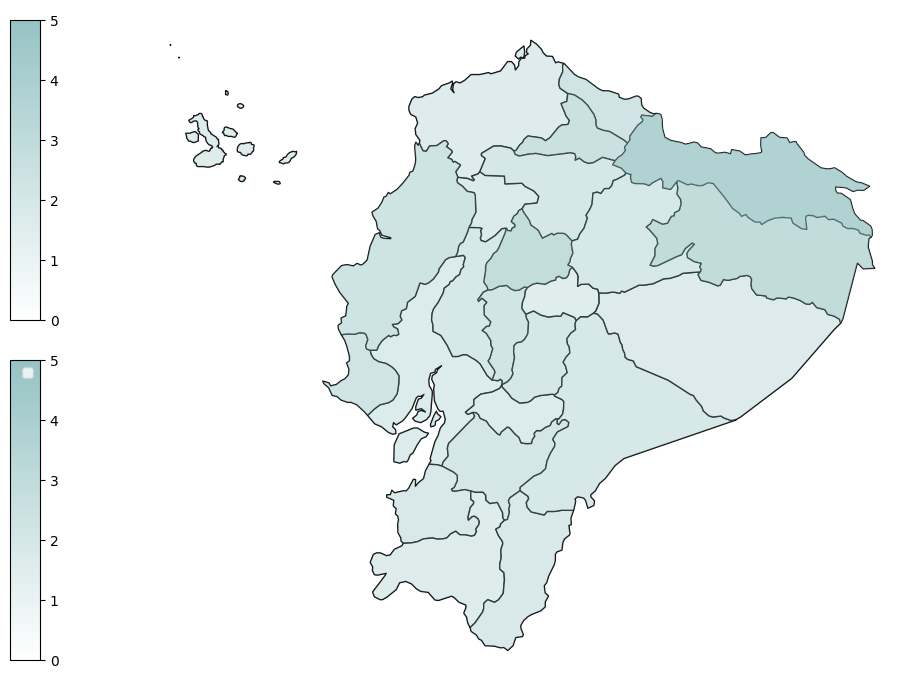

In [178]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize,ListedColormap,LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase


# Load GeoJSON file
gdf = gpd.read_file("Ecuador.geojson")
gdf['name']=gdf['name'].str.upper()
gdf['name'] = gdf['name'].str.replace('SANTO DOMINGO DE LOS TSACHILAS','STO DGO TSACHILAS')

# Prepare your score data
score_data = {
    "Guayas": 0.8,
    "Esmeraldas": 0.6,
    "Carchi": 0.7,
    "Imbabura": 0.9,
    "Sucumbios": 1
}

score_data_no = {
    "Pichincha": 0.8,
    "El Oro": 0.6,
    "Los Rios": 0.7,
    "Loja": 0.9,
    "Galapagos  ": 0.5
}

color_si = '#0083E9'
color_no =  '#E99100'
# Plot the shapes with a heatmap-like effect based on the score
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='black')

for name, score in dic_NO.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color='#96c3c4', alpha=score, linewidth=0, label=name)
    
for name, score in dic_SI.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color='red', alpha=score, linewidth=0, label=name)

# Define the color
color_hex = '#96c3c4'

# Create a colormap with a gradient using the specified color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_hex)])

# Define the range of values for the color bar
values = [0, 1, 2, 3, 4, 5]

# Add colorbar
norm = Normalize(vmin=min(values), vmax=max(values))
cbar = ColorbarBase(ax=fig.add_axes([0, 0.52, 0.03, 0.3]), cmap=cmap, norm=norm)


# Define the color
color_hex = '#96c3c4'

# Create a colormap with a gradient using the specified color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_hex)])

# Define the range of values for the color bar
values = [0, 1, 2, 3, 4, 5]

# Add colorbar
norm = Normalize(vmin=min(values), vmax=max(values))
cbar = ColorbarBase(ax=fig.add_axes([0, 0.18, 0.03, 0.3]), cmap=cmap, norm=norm)


#plt.xlabel('Maximo')
#plt.ylabel('Minimo')
plt.legend()
ax.axis('off')
# Save the plot as a PNG image
plt.savefig('mapas/heatmap_plot.png', dpi=300,transparent = True)  # Adjust dpi as needed
plt.show()




In [156]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Define el color hexadecimal
color_hex = '#96c3c4'

# Crea un mapa de color con un gradiente usando el color especificado
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#ffffff'), (1, color_hex)])

# Define el rango de valores para el colorbar
values = [0, 1, 2, 3, 4, 5]

# Crea un objeto Normalizar para mapear los valores al rango 0-1
norm = Normalize(vmin=min(values), vmax=max(values))

# Lista de valores para los que quieres obtener el color correspondiente
valores_a_convertir = [1, 3, 4]

# Obtiene los colores correspondientes a los valores dados
colores_correspondientes = [cmap(norm(valor)) for valor in valores_a_convertir]

# Convierte los colores de formato RGB a formato hexadecimal
colores_hex = [plt.cm.colors.to_hex(color) for color in colores_correspondientes]

# O puedes imprimir los colores en formato RGB directamente
colores_rgb = [plt.cm.colors.to_rgba(color, alpha=False) for color in colores_correspondientes]

print("Valores:", valores_a_convertir)
print("Colores correspondientes en formato Hex:", colores_hex)
print("Colores correspondientes en formato RGB:", colores_rgb)


Valores: [1, 3, 4]
Colores correspondientes en formato Hex: ['#eaf3f3', '#c0dbdc', '#abcfd0']
Colores correspondientes en formato RGB: [(0.9176470588235294, 0.9529411764705882, 0.9537254901960784, False), (0.7529411764705882, 0.8588235294117647, 0.8611764705882353, False), (0.6705882352941177, 0.8117647058823529, 0.8149019607843138, False)]


/var/folders/0q/l5j608j10jq82grhg4m4pf0h0000gn/T/ipykernel_46389/2639955594.py:30: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/var/folders/0q/l5j608j10jq82grhg4m4pf0h0000gn/T/ipykernel_46389/2639955594.py:36: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


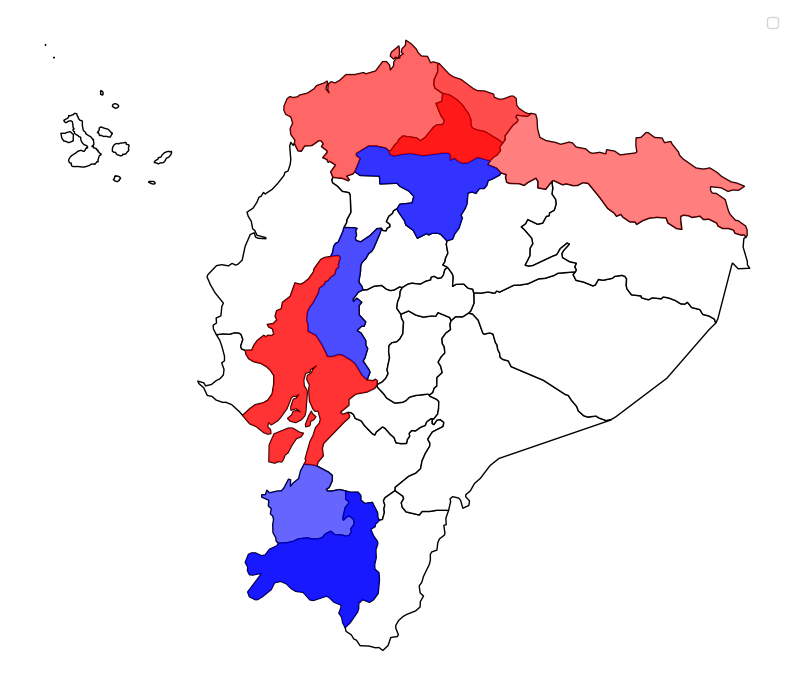

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load GeoJSON file
gdf = gpd.read_file("Ecuador.geojson")

# Prepare your score data
score_data = {
    "Guayas": 0.8,
    "Esmeraldas": 0.6,
    "Carchi": 0.7,
    "Imbabura": 0.9,
    "Sucumbios": 0.5
}

score_data_no = {
    "Pichincha": 0.8,
    "El Oro": 0.6,
    "Los Rios": 0.7,
    "Loja": 0.9,
    "Galapagos  ": 0.5
}

# Plot the shapes with a heatmap-like effect based on the score
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='black')

for name, score in score_data_no.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color='blue', alpha=score, linewidth=0, label=name)
    
for name, score in score_data.items():
    shape = gdf[gdf['name'] == name]
    shape.plot(ax=ax, color='red', alpha=score, linewidth=0, label=name)

plt.legend()

# Remove the outer box around the plot
ax.axis('off')

# Save the plot as a PNG image
plt.savefig('heatmap_plot.png', dpi=300)  # Adjust dpi as needed
plt.show()
